In [1]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from xgboost import XGBClassifier
from skrules import SkopeRules
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from joblib import Parallel, delayed

rnd_state = 40

In [2]:
import numpy as np
from sklearn.datasets import make_moons

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

from sklearn.model_selection import train_test_split

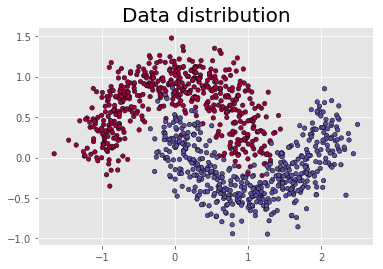

In [3]:
X_moons, y_moons = make_moons(n_samples=1000, shuffle=True, noise=0.2, random_state=rnd_state)
# plt.figure(figsize=(12,8))
plt.scatter(X_moons[:,0],X_moons[:,1], s=20, c=y_moons, cmap=plt.cm.Spectral, edgecolor = 'k')
plt.title("Data distribution", size=20)
plt.show()

In [4]:
x_min, y_min = np.min(X_moons, axis = 0)
x_max, y_max = np.max(X_moons, axis = 0)
h = 0.1
xx, yy = np.meshgrid(np.arange(x_min-1, x_max+1, h),
                     np.arange(y_min-1, y_max+1, h))

grid = np.c_[xx.ravel(), yy.ravel()]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_moons, y_moons, random_state = rnd_state )

In [19]:
def find_model(x,y, models_list = ['all'], cv = 3, scoring = 'roc_auc', max_evals = 1000, n_jobs = -1, verbose = 10):
    '''
        Input:  - x: matrix of features
                - y: vector of labels
                - models_list:if 'all' then all space_list will be covered, otherwise you can specify the 
                                algorithm you want to cover
                - cv: cross-validation
                - scoring: AUC by default, check sklearn for more scoring, but note that all may not be
                            compatible with every algorithm
                - max_evals: number of iteration for the optimization
                - n_jobs = number of process
        Output: - dict with the key being ths classifier and the value the best params
                
                
    '''
    ### Cost function which returns the cross_val_Score depending on the considered classifier ###
    def hyperopt_train_test2(params):
        t = params['type']
        del params['type']
        if t == 'naive_bayes':
            clf = BernoulliNB(**params)
        elif t == 'svm':
            clf = SVC(**params)
        elif t == 'dtree':
            clf = DecisionTreeClassifier(**params)
        elif t == 'knn':
            clf = KNeighborsClassifier(**params)
        elif t == 'xgboost':
            clf = XGBClassifier(**params)
        elif t == 'skoperules':
            params['n_estimators']=int(params['n_estimators']) #there is a bug in hyperopt, quniform returns a float
            clf = SkopeRules(**params)
        elif t == 'randomforest':
            params['n_estimators']=int(params['n_estimators'])
            clf = RandomForestClassifier(**params)
        else:
            return 0
        return cross_val_score(clf, x, y, scoring = scoring, cv=cv).mean()

    ### Minimization function ###
    def f(params):
        acc = hyperopt_train_test2(params.copy())
        return {'loss': -acc, 'status': STATUS_OK}

    ### space_list defines the optimization space for each classifier, you should modify to suit your data ###
    space_list =[
            {
                'type': 'naive_bayes',
                'alpha': hp.uniform('alpha', 0.0, 2.0)
            },
            {
                'type': 'svm',
                'C': hp.uniform('C', 0, 10.0),
                'kernel': hp.choice('kernel', ['linear', 'rbf']),
                'gamma': hp.uniform('gamma', 0, 10.0)
            },
            {
                'type': 'randomforest',
                'max_depth': hp.quniform('max_depth', 1,20,1),
                'max_features': hp.choice('max_features', range(1,2)),
                'n_estimators': hp.quniform('n_estimators', 100,500,100),
                'criterion': hp.choice('criterion', ["gini", "entropy"])
            },
            {
                'type': 'xgboost',
                'n_estimators': hp.quniform('n_estimators_xgb', 100,400,50),
                'max_depth': hp.choice('max_depth', range(1,20)),
                'max_features': hp.choice('max_features', range(1,5)),
                'min_child_weight':hp.quniform('min_child_weight', 0.5,1.0,0.1),
                'gamma': hp.uniform('gamma', 0, 10.0)
            },
            {
                'type': 'skoperules',
                'n_estimators': hp.quniform('n_estimators1', 10,60,5),
                'precision_min': hp.choice('precision_min', [0.1, 0.2, 0.3, 0.4]),
                'recall_min': hp.choice('recall_min', [0.001, 0.01, 0,1])
            },
            {
                'type': 'knn',
                'n_neighbors': hp.choice('knn_n_neighbors', range(1,50)),
                'p' : hp.choice('p',[1,2,3])
                
            }
        ]
    
    if models_list[0] != 'all':
        space_list = space_list[models_list]
#     trials = [Trials()]*len(space_list) #trials not working
    res = Parallel(n_jobs=n_jobs, verbose = verbose)(delayed(fmin)(f, space, algo=tpe.suggest, max_evals=max_evals) for j,space in enumerate(space_list))
    res_dict = {space_list[i]['type']:res[i] for i in range(len(space_list))}
    return res_dict

In [20]:
res = find_model(X_train, y_train, max_evals = 10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    1.3s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    1.6s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    2.2s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   57.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   57.5s finished


In [21]:
res

{'knn': {'knn_n_neighbors': 33, 'p': 0},
 'naive_bayes': {'alpha': 0.12516185866809315},
 'randomforest': {'criterion': 1,
  'max_depth': 11.0,
  'max_features': 0,
  'n_estimators': 400.0},
 'skoperules': {'n_estimators1': 25.0, 'precision_min': 1, 'recall_min': 1},
 'svm': {'C': 9.692482019808441, 'gamma': 1.2935559459995771, 'kernel': 1},
 'xgboost': {'gamma': 0.02563436584372414,
  'max_depth': 4,
  'max_features': 2,
  'min_child_weight': 0.6000000000000001}}